In [1]:
import pandas as pd
import numpy as np
import pylab
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
%matplotlib inline

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Let's simulate a time series process that follows the following AR2 model:

$y_t = 0.75 y_{t - 1} + 0.2 y_{t - 2} + \epsilon$ where $\epsilon \sim N(0, 1)$

<AxesSubplot:>

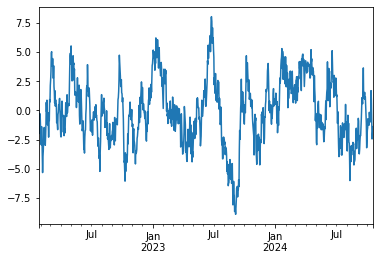

In [30]:
n = 1000

startdate = '2022-01-25'
daterange = pd.date_range(start=startdate, periods=1000)

empty_dataset = np.zeros(n)
mod = SARIMAX(empty_dataset, order=(2, 0, 0), initialization='diffuse')
simulations = pd.Series(mod.simulate([0.75, 0.2, 1], n), index=daterange)
simulations.plot()

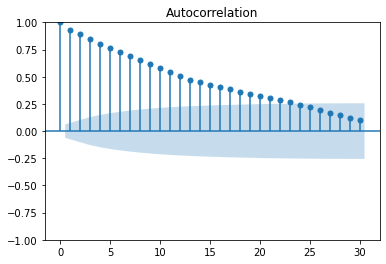

In [31]:
acf_plot = plot_acf(simulations)

A slowly decaying ACF plot indicates an autoregressive process

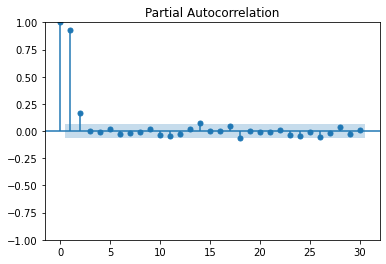

In [32]:
pacf_plot = plot_pacf(simulations, method='ywm')

The PACF function shuts off after two lags. So we estimate that it's an AR2 process

In [34]:
# we will train up until Sep 30th, 2024
train_end = datetime(2024, 9, 1)

train_data = simulations[:train_end]
test_data = simulations[train_end + timedelta(days=1):]

In [35]:
#create the model
model = SARIMAX(train_data, order=(2, 0, 0))
#fit the model
model_fit = model.fit()
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  951
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1346.507
Date:                Sun, 30 Jan 2022   AIC                           2699.015
Time:                        17:27:46   BIC                           2713.587
Sample:                    01-25-2022   HQIC                          2704.567
                         - 09-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7627      0.032     23.560      0.000       0.699       0.826
ar.L2          0.1822      0.032      5.736      0.000       0.120       0.244
sigma2         0.9917      0.049     20.232      0.0

The best fit AR2 model is:
$\hat{y_t} = 0.76y_{t - 1} + 0.18y_{t - 2}$

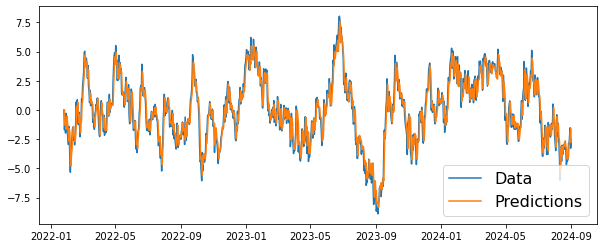

In [43]:
pylab.figure(figsize=(10,4))

pylab.plot(train_data)
pylab.plot(model_fit.predict(start=train_data.index[0], end=train_data.index[-1]))

pylab.legend(('Data', 'Predictions'), fontsize=16)

In [37]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [39]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

Text(0.5, 1.0, 'AR2 Simulatition over time')

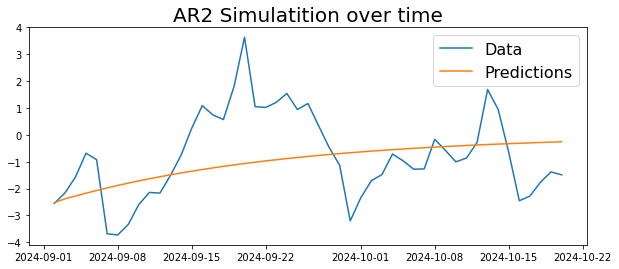

In [42]:
pylab.figure(figsize=(10,4))

pylab.plot(test_data)
pylab.plot(predictions)

pylab.legend(('Data', 'Predictions'), fontsize=16)

pylab.title('AR2 Simulatition over time', fontsize=20)

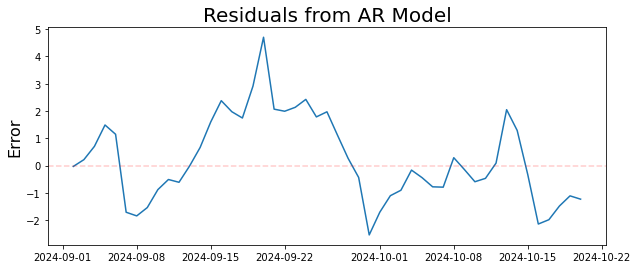

In [44]:
pylab.figure(figsize=(10, 4))
pylab.plot(residuals)
pylab.title('Residuals from AR Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)
pylab.axhline(0, color='r', linestyle='--', alpha=0.2)

There is no clear pattern/trend in the residuals, which is a good sign that our model isn't overly simplistic. Let's use a couple of metrics to evaluate the performance of the model

In [46]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 1.1203


In [47]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.5681663527606067


One thing that the plot above shows is that time series predictions lose value over time. This is because time series predictions depend on the previous prediction, so errors compound. An alternative way to evaluate a time series model is rolling forecast residuals. For each test data point, we train up to (but not including) that data point, then make a prediction for that data point. This evaluates how well the model does when it has all of the information it needs

Text(0, 0.5, 'Error')

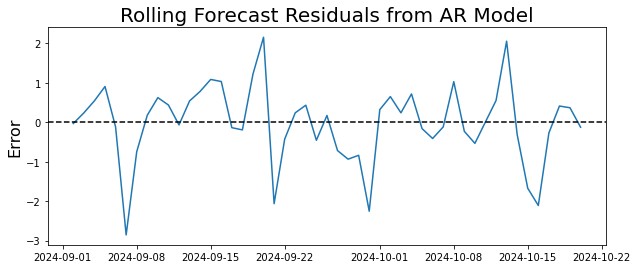

In [52]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = simulations[:train_end - timedelta(days=1)]
    model = SARIMAX(train_data, order=(2,0,0))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred
    
rolling_residuals = test_data - rolling_predictions
pylab.figure(figsize=(10,4))
pylab.plot(rolling_residuals)
pylab.axhline(0, linestyle='--', color='k')
pylab.title('Rolling Forecast Residuals from AR Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)

The rolling forecast resituals are more accurate. Let's see if our evaluation metrics bear that out.

In [53]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.7784


In [54]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 0.9789806872730231


Our mean absolute percent error and root mean squared error are both smaller

For another example of autoregression, see this example from RitvikMath
- Jupyter notebook: https://github.com/sia-mak/Time-Series/blob/main/AR%20Model.ipynb
- Companion video: https://www.youtube.com/watch?v=JCKMV0Cuk0k&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=23
